In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import mlflow

# Predicción de Enfermedades del Corazón

En este ejemplo, trabajaremos con el famoso conjunto de datos "UCI Heart Disease". Este conjunto de datos contiene un conjunto de atributos relacionados con pacientes potencialmente afectados por una enfermedad cardiovascular (ECV). Las ECV son una de las principales causas de mortalidad, pero se estima que hasta un 90% de las ECV podrían ser prevenibles. Un diagnóstico temprano podría ser esencial en la mayoría de los casos y la inteligencia artificial puede lograr este objetivo.


## Clasificación Binaria en Aprendizaje Automático

### Entrenamiento de un Clasificador Binario
1. **Preparación de Datos**: Divide el conjunto de datos en entrenamiento y prueba.
2. **Selección del Modelo**: Elige un modelo de clasificación binaria (ej. regresión logística).
3. **Entrenamiento del Modelo**: Entrena el modelo usando una biblioteca como sklearn.
4. **Ajuste de Hiperparámetros**: Mejora el rendimiento ajustando los hiperparámetros.

### Evaluación del Clasificador Binario
1. **Matriz de Confusión**: Muestra predicciones correctas e incorrectas divididas en dos clases.
2. **Precisión (Precision)**: Proporción de identificaciones positivas correctas.
   - `Precisión = VP / (VP + FP)`
3. **Recall (Sensibilidad)**: Proporción de positivos reales identificados correctamente.
   - `Recall = VP / (VP + FN)`
4. **Puntuación F1 (F1 Score)**: Promedio ponderado de precisión y recall.
   - `F1 = 2 * (Precisión * Recall) / (Precisión + Recall)`
5. **Curva ROC y AUC**: Rendimiento del clasificador y medida agregada de rendimiento.
6. **Validación Cruzada**: Evalúa la robustez del modelo.

In [2]:
# leemos los datos
data = pd.read_csv('../data/raw/heart.csv')

In [4]:
# Vamos a echar un ojo a los datos que tenemos
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,Male,asymptomatic,145.0,233.0,True,normal,150,No,2.3,upsloping,0,1,1
1,37,Male,non-anginal pain,NaN,250.0,False,having ST-T wave abnormality,187,No,3.5,upsloping,0,2,1
2,41,Female,atypical angina,NaN,204.0,False,normal,172,No,1.4,downsloping,0,2,1
3,56,Male,atypical angina,120.0,236.0,False,having ST-T wave abnormality,178,No,0.8,downsloping,0,2,1
4,57,Female,typical angina,120.0,NaN,False,having ST-T wave abnormality,163,Yes,0.6,downsloping,0,2,1


1. **age**: edad en años.
2. **sex**: sexo (1 = masculino; 0 = femenino).
3. **cp**: tipo de dolor de pecho.
   - Valor 1: angina típica.
   - Valor 2: angina atípica.
   - Valor 3: dolor no anginoso.
   - Valor 4: asintomático.
4. **trestbps**: presión arterial en reposo (en mm Hg al ingresar al hospital).
5. **chol**: colesterol sérico en mg/dl.
6. **fbs**: azúcar en sangre en ayunas > 120 mg/dl (1 = verdadero; 0 = falso).
7. **restecg**: resultados electrocardiográficos en reposo.
   - Valor 0: normal.
   - Valor 1: con anormalidad de onda ST-T (inversiones de onda T y/o elevación o depresión del ST de > 0.05 mV).
   - Valor 2: muestra probable o definitiva hipertrofia ventricular izquierda según los criterios de Estes.
8. **thalach**: frecuencia cardíaca máxima alcanzada.
9. **exang**: angina inducida por el ejercicio (1 = sí; 0 = no).
10. **oldpeak**: depresión del segmento ST inducida por el ejercicio en relación al reposo.
11. **slope**: la pendiente del segmento ST durante el pico del ejercicio.
    - Valor 1: ascendente.
    - Valor 2: plano.
    - Valor 3: descendente.
12. **ca**: número de vasos principales (0-3) coloreados por fluoroscopia.
13. **thal**: 3 = normal; 6 = defecto fijo; 7 = defecto reversible.
14. **target**: variable objetivo, se refiere a la presencia de enfermedad cardíaca en el paciente.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  258 non-null    float64
 4   chol      273 non-null    float64
 5   fbs       303 non-null    bool   
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: bool(1), float64(3), int64(5), object(5)
memory usage: 31.2+ KB


In [6]:
data.describe()

,age,trestbps,chol,thalach,oldpeak,ca,thal,target
count,303.000000,258.000000,273.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.465116,245.871795,149.646865,1.039604,0.729373,2.313531,0.544554
std,9.082101,16.914317,52.528792,22.905161,1.161075,1.022606,0.612277,0.498835
min,29.000000,94.000000,131.000000,71.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,209.000000,133.500000,0.000000,0.000000,2.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000,2.000000,1.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,3.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,3.000000,1.000000


La edad media es de 54 años, los adultos tienen más probabilidades que los jóvenes de sufrir enfermedades cardiovasculares.

In [7]:
# vamos echar un ojo al target
data.target.value_counts()

target
1    165
0    138
Name: count, dtype: int64

El dataset esta balanceado

In [ ]:
# train test split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=5)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>],
       [<Axes: title={'center': 'thalach'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>,
        <Axes: title={'center': 'target'}>, <Axes: >]], dtype=object)

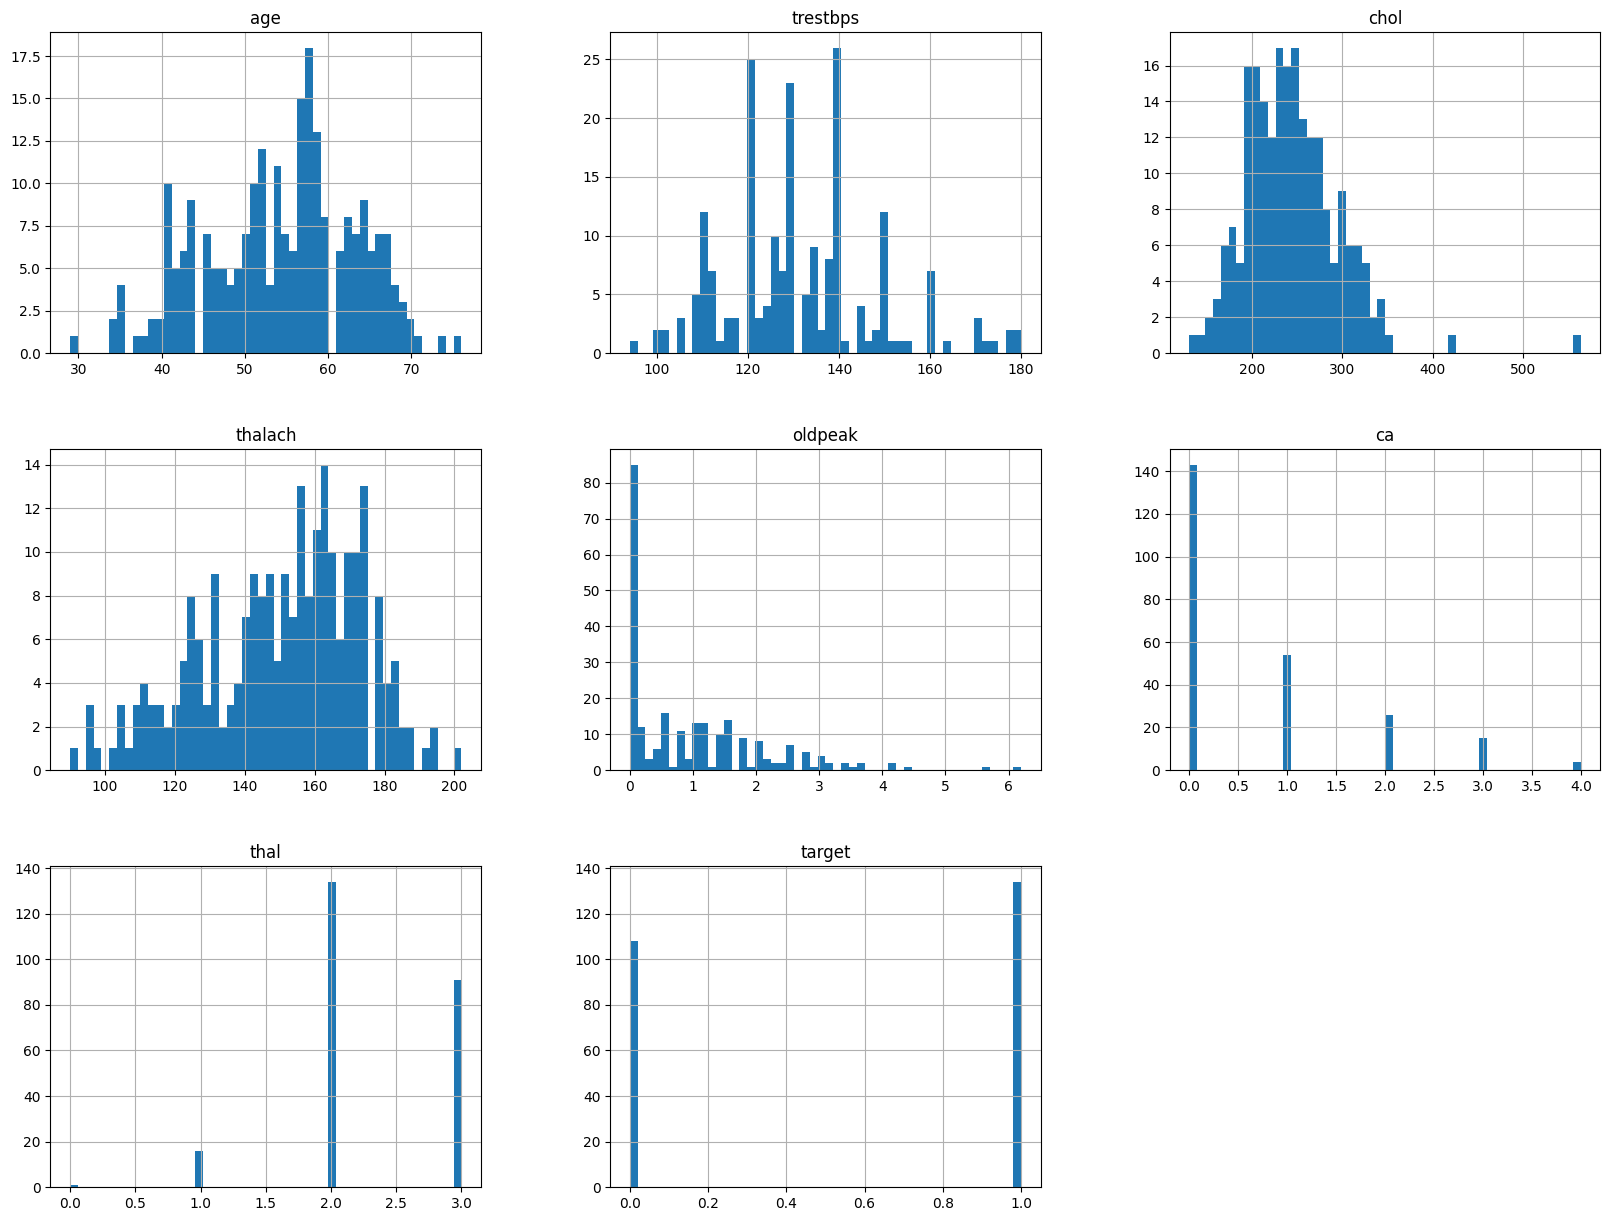

In [9]:
# Vamos a hacer un plot de las distirbuciones de todas las columnas
train_set.hist(bins=50, figsize=(20, 15))

Las características tienen diferentes escalas, por lo que es una buena idea realizar un standard scaling.

In [10]:
# Creeamos un pipeline para hacer un one hot encoding de las variables categoricas y además, hacemos un median target encoding para los valores nulos.
# finalmente estandarizamos las escalas de las columnas
cat_attr = ["sex", "cp", "fbs", "restecg", "exang", "slope"]
num_attr = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca", "thal"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attr),
    ("cat", OneHotEncoder(), cat_attr)
])

In [11]:
x_train = train_set.drop("target", axis=1)
y_train = train_set.target

In [12]:
x_train_pr = full_pipeline.fit_transform(x_train)

# Entrenamiento del modelo y evaluacion

Vamos a probar con un simple clasificador binario como base, en este caso un Clasificador estocástico por descenso de gradiente (SGD)

In [14]:
# La forma recomendada de comenzar a usar el seguimiento de MLflow con Python es utilizar la API autolog() de MLflow.
# Con las capacidades de autologging de MLflow, una sola línea de código registra automáticamente el modelo resultante, los parámetros utilizados para crear el modelo y una puntuación del modelo.
mlflow.sklearn.autolog()

# Esta vez quiero usar un experimento específico
mlflow.set_experiment("Experimento de Enfermedad Cardíaca")

2023/11/16 13:19:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


<Experiment: artifact_location='file:///Users/christof/code/mlflow-workshop/mlflow_tutorial/notebooks-sol/mlruns/341612625127429321', creation_time=1700137145806, experiment_id='341612625127429321', last_update_time=1700137145806, lifecycle_stage='active', name='Heart Disease Experiment', tags={}>

In [15]:
mlflow.start_run()

<ActiveRun: >

In [16]:
sgd_clf = SGDClassifier(random_state=42)

Casi siempre una buena de evaluar el modelo es realizando una validacion cruzada

In [17]:
scores = cross_val_score(sgd_clf, x_train_pr, y_train, cv=3, scoring="accuracy")
scores.mean()

2023/11/16 13:19:49 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/11/16 13:19:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/christof/code/mlflow-workshop/mlflow-env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/11/16 13:19:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/11/16 13:19:52 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


0.7604423868312757

In [18]:
mlflow.log_metric("cv_score", scores.mean())

"No es una gran metrica. Creo que es mejor idea evaluar nuestro modelo utilizando otras herramientas como la matriz de confusión.

In [19]:
# es como la validacion cruzada pero te devuelve las predcciones
preds = cross_val_predict(sgd_clf, x_train_pr, y_train, cv=3)

2023/11/16 13:19:53 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/11/16 13:19:55 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/11/16 13:19:56 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


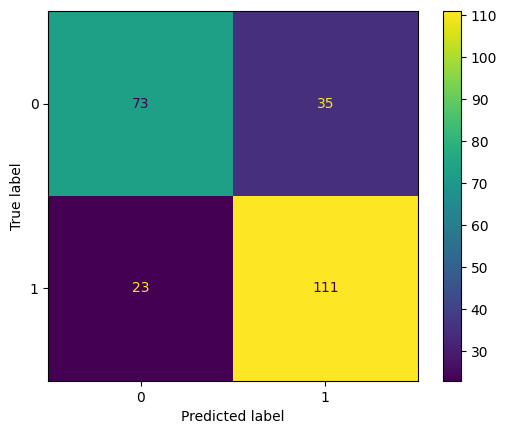

In [20]:
# Ahora ploteamos la matriz de confusión
cm = confusion_matrix(y_train, preds)
ConfusionMatrixDisplay(cm).plot()

Vamos a ver la precisión, recall y F1 Score

In [21]:
precision = precision_score(y_train, preds)
print("Precision: ", precision)
recall = recall_score(y_train, preds)
print("Recall: ", recall)
f1 = f1_score(y_train, preds)
print("F1 score: ", f1)

Precision:  0.7602739726027398
Recall:  0.8283582089552238
F1 score:  0.7928571428571429


In [22]:
# Otra metrica top para los clasificadores es el roc auc score
roc_auc = roc_auc_score(y_train, preds)
print("roc auc score:", roc_auc)

roc auc score: 0.7521420674405749


In [23]:
# logueamos todas nuestras métricas
mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("F1 score", f1)
mlflow.log_metric("roc auc score", roc_auc)

In [24]:
mlflow.end_run()

Pienso que es mejor empezar a usar modelos mas potentes como un RandomForestClassifier

In [25]:
mlflow.start_run()

<ActiveRun: >

In [26]:
rf_clf = RandomForestClassifier(random_state=42)
rf_preds = cross_val_predict(rf_clf, x_train_pr, y_train, cv=3)

2023/11/16 13:19:58 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/11/16 13:19:59 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/11/16 13:20:00 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


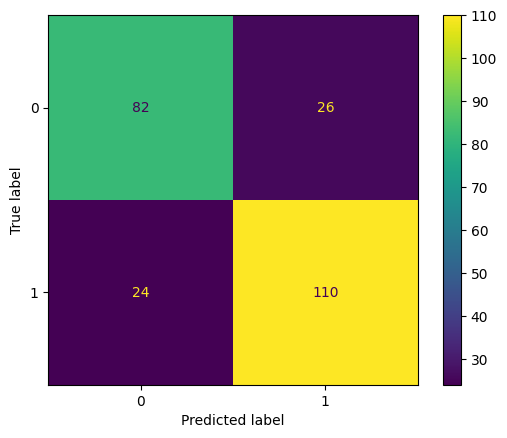

In [27]:
cm = confusion_matrix(y_train, rf_preds)
ConfusionMatrixDisplay(cm).plot()

In [28]:
precision = precision_score(y_train, rf_preds)
print("Precision: ", precision)
recall = recall_score(y_train, rf_preds)
print("Recall: ", recall)
f1 = f1_score(y_train, rf_preds)
print("F1 score: ", f1)
roc_auc = roc_auc_score(y_train, rf_preds)
print("roc auc score:", roc_auc)

Precision:  0.8088235294117647
Recall:  0.8208955223880597
F1 score:  0.8148148148148148
roc auc score: 0.7900773908236595


In [29]:
mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("F1 score", f1)
mlflow.log_metric("roc auc score", roc_auc)

In [30]:
mlflow.end_run()

Un poco mejor que nuestro modelo baseline. vamos a entrenar un random forest usando todo el dataset y a ver que tal sale

In [31]:
mlflow.start_run()

<ActiveRun: >

In [32]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(x_train_pr, y_train)

2023/11/16 13:20:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


RandomForestClassifier(random_state=42)

In [33]:
x_test = test_set.drop("target", axis=1)
y_test = test_set.target

In [34]:
x_test_pr = full_pipeline.transform(x_test)
final_preds = forest_clf.predict(x_test_pr)

In [35]:
# Printeamos las métricas
print("Precision: ", precision_score(y_test, final_preds))
print("Recall: ", recall_score(y_test, final_preds))
print("F1 score: ", f1_score(y_test, final_preds))
print("roc auc score:", roc_auc_score(y_test, final_preds))

Precision:  0.8787878787878788
Recall:  0.9354838709677419
F1 score:  0.90625
roc auc score: 0.9010752688172043


In [36]:
precision = precision_score(y_test, final_preds)
print("Precision: ", precision)
recall = recall_score(y_test, final_preds)
print("Recall: ", recall)
f1 = f1_score(y_test, final_preds)
print("F1 score: ", f1)
roc_auc = roc_auc_score(y_test, final_preds)
print("roc auc score:", roc_auc)

Precision:  0.8787878787878788
Recall:  0.9354838709677419
F1 score:  0.90625
roc auc score: 0.9010752688172043


In [37]:
mlflow.log_metric("Precision", precision)
mlflow.log_metric("Recall", recall)
mlflow.log_metric("F1 score", f1)
mlflow.log_metric("roc auc score", roc_auc)

In [38]:
mlflow.end_run()

In [39]:
! mlflow ui

[2023-11-16 13:20:04 +0100] [86232] [INFO] Starting gunicorn 21.2.0
[2023-11-16 13:20:04 +0100] [86232] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-11-16 13:20:04 +0100] [86232] [ERROR] Retrying in 1 second.
[2023-11-16 13:20:05 +0100] [86232] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-11-16 13:20:05 +0100] [86232] [ERROR] Retrying in 1 second.
[2023-11-16 13:20:06 +0100] [86232] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-11-16 13:20:06 +0100] [86232] [ERROR] Retrying in 1 second.
[2023-11-16 13:20:07 +0100] [86232] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-11-16 13:20:07 +0100] [86232] [ERROR] Retrying in 1 second.
[2023-11-16 13:20:08 +0100] [86232] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-11-16 13:20:08 +0100] [86232] [ERROR] Retrying in 1 second.
[2023-11-16 13:20:09 +0100] [86232] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.


Este fue un ejemplo sencillo de cómo evaluar un clasificador, ¡sin embargo, el resultado es bueno! La validación cruzada es un buen método para evaluar modelos, pero como dividimos nuestro conjunto de datos en 3 partes, el modelo tuvo pocos datos para lograr buenos resultados. ¡Con el conjunto de datos completo alcanzamos un buen resultado!